# Error Analysis

In [56]:
# libraries
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from PIL import Image as PilImage
from typing import Tuple
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import L2
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# working directories
WORKDIR = os.path.abspath('D:\\Users\\nbakotic\\iccecme-dataset\\test') # get the path of this file - image metadata
MAXBIT= os.path.join(WORKDIR, 'maxbit')  # get the path of image folder
MAXPEAK = os.path.join(WORKDIR, 'maxpeak')

# gpu setup
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

MAXCENTER = 32767.0 
MAXWIDTH = 65535.0 

In [11]:
# plot relationship between real and predicted values
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.show()


# plot a metric from the given model training history
def plot_metrics(history, metric_name, title):
    plt.title(title)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

In [15]:
# format datasets - return tuple of labels as arrays
def format_output(data):
    window_center = data.pop('WindowCenter')
    window_center = np.array(window_center)
    window_width = data.pop('WindowWidth')
    window_width = np.array(window_width)
    return window_center, window_width

def scale_image(image):
    train_means = 57.33223588599136
    train_stddev = 64.42799224651517
    return (image - train_means) / train_stddev

# load png images using dataframe index as file names and return a numpy array of images
def get_image(df):
    x_img = []

    for id in df.index:
        
        img = np.array(PilImage.open(os.path.join(MAXBIT, str(id) + '.png')).convert('L'))
        # 1 grayscale dimension is dropped by default so it's added back manually
        img = np.expand_dims(img, -1) 

        x_img.append(img)

    x_img = np.array(x_img)

    return x_img

In [38]:
# load png images using dataframe index as file names and return a numpy array of images
x_test = pd.read_csv(os.path.join(WORKDIR, 'x_test.csv'), index_col='id')
y_test = pd.read_csv(os.path.join(WORKDIR, 'y_test.csv'), index_col='id')

ids = y_test.index

y_test = format_output(y_test)

x_test_img = get_image(x_test)

x_test_metadata = np.array(x_test)

In [40]:
#Model predictions
mo_model = tf.keras.models.load_model('./mo_model/') 
mi_model = tf.keras.models.load_model('./mi_model/') 

test_center = y_test[0]
test_width = y_test[1]

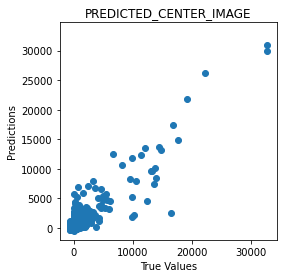

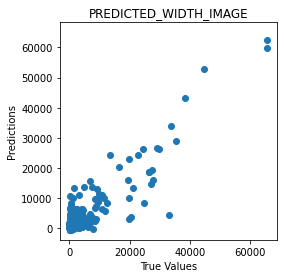

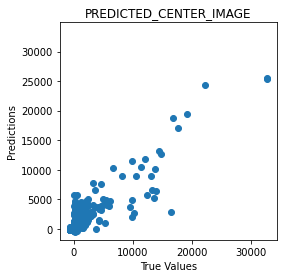

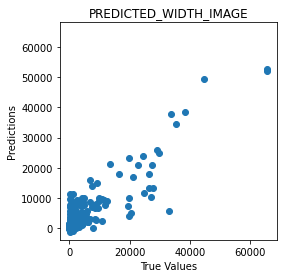

The accuracy of WindowCenter is 83.0%
The accuracy of WindowWidth is 79.0%
Mean absolute error of WindowCenter is 283.69
Mean absolute error of WindowWidth is 594.45
Mean squared error of WindowCenter is 328613.58, RMSE: 573.25
Mean squared error of WindowWidth is 1371984.13, RMSE: 1171.32
The accuracy of WindowCenter is 84.0%
The accuracy of WindowWidth is 80.0%
Mean absolute error of WindowCenter is 213.72
Mean absolute error of WindowWidth is 477.29
Mean squared error of WindowCenter is 298054.08, RMSE: 545.94
Mean squared error of WindowWidth is 1296880.52, RMSE: 1138.81


In [92]:
predicted_image = mo_model.predict(scale_image(x_test_img))
predicted_image_center = predicted_image[0].reshape(-1) / 255.0 * MAXCENTER
predicted_image_width = predicted_image[1].reshape(-1) / 255.0 * MAXWIDTH

predicted_metadata = mi_model.predict([scale_image(x_test_img), x_test_metadata])
predicted_metadata_center = predicted_metadata[0].reshape(-1) / 255.0 * MAXCENTER
predicted_metadata_width = predicted_metadata[1].reshape(-1) / 255.0 * MAXWIDTH

# difference between true and predicted values
plot_diff(test_center, predicted_image_center, title='PREDICTED_CENTER_IMAGE')
plot_diff(test_width, predicted_image_width, title='PREDICTED_WIDTH_IMAGE')
plot_diff(test_center, predicted_metadata_center, title='PREDICTED_CENTER_IMAGE')
plot_diff(test_width, predicted_metadata_width, title='PREDICTED_WIDTH_IMAGE')

# calculate and print metrics
mo_score_center = r2_score(test_center, predicted_image_center)
print("The accuracy of WindowCenter is {}%".format(round(mo_score_center, 2) *100))
mo_score_width = r2_score(test_width, predicted_image_width)
print("The accuracy of WindowWidth is {}%".format(round(mo_score_width, 2) *100))

mo_mae_center =  mean_absolute_error(test_center, predicted_image_center .reshape(-1))
print("Mean absolute error of WindowCenter is {}".format(round(mo_mae_center, 2)))
mo_mae_width =  mean_absolute_error(test_width, predicted_image_width.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mo_mae_width, 2)))

mo_mse_center = mean_squared_error(test_center, predicted_image_center)
print("Mean squared error of WindowCenter is {}, RMSE: {}".format(round(mo_mse_center, 2), round(np.sqrt(mo_mse_center), 2)))
mo_mse_width = mean_squared_error(test_width, predicted_image_width)
print("Mean squared error of WindowWidth is {}, RMSE: {}".format(round(mo_mse_width, 2), round(np.sqrt(mo_mse_width), 2)))


# calculate and print metrics
mi_score_center = r2_score(test_center, predicted_metadata_center)
print("The accuracy of WindowCenter is {}%".format(round(mi_score_center, 2) *100))
mi_score_width = r2_score(test_width, predicted_metadata_width)
print("The accuracy of WindowWidth is {}%".format(round(mi_score_width, 2) *100))

mi_mae_center =  mean_absolute_error(test_center, predicted_metadata_center)
print("Mean absolute error of WindowCenter is {}".format(round(mi_mae_center, 2)))
mi_mae_width =  mean_absolute_error(test_width, predicted_metadata_width)
print("Mean absolute error of WindowWidth is {}".format(round(mi_mae_width, 2)))

mi_mse_center = mean_squared_error(test_center, predicted_metadata_center)
print("Mean squared error of WindowCenter is {}, RMSE: {}".format(round(mi_mse_center, 2), round(np.sqrt(mi_mse_center), 2)))
mi_mse_width = mean_squared_error(test_width, predicted_metadata_width)
print("Mean squared error of WindowWidth is {}, RMSE: {}".format(round(mi_mse_width, 2), round(np.sqrt(mi_mse_width), 2)))




predicted_image_df = pd.DataFrame({"Index": ids,
                                   "Predicted window center (image only)": predicted_image_center,
                                   "Actual window center": test_center,
                                   "Difference center":np.abs(test_center - predicted_image_center),
                                   "Predicted window width (image only)": predicted_image_width,
                                   "Actual window width": test_width,
                                   "Difference width":np.abs(test_width - predicted_image_width),
                                   })
predicted_metadata_df = pd.DataFrame({"Index": ids,
                                      "Predicted window center (with metadata)": predicted_metadata_center,
                                      "Actual window center": test_center,
                                      "Difference center":np.abs(test_center - predicted_metadata_center),
                                      "Predicted window width (with metadata)": predicted_metadata_width,
                                      "Actual window width": test_width,
                                      "Difference width":np.abs(test_width - predicted_metadata_width)
                                    })

In [98]:
predicted_image_df.sort_values("Difference width", axis=0, ascending=True)

,Index,Predicted window center (image only),Actual window center,Difference center,Predicted window width (image only),Actual window width,Difference width
4801,16377911,20.991079,40.0,19.008921,299.771667,300.0,0.228333
4655,19738309,352.572021,358.0,5.427979,444.444855,444.0,0.444855
2259,19740181,1752.591797,1486.0,266.591797,2972.501953,2973.0,0.498047
1280,13567072,31.284523,96.0,64.715477,191.849106,193.0,1.150894
3845,16038508,365.457153,380.0,14.542847,439.380615,438.0,1.380615
...,...,...,...,...,...,...,...
4370,25902931,7489.509277,13568.0,6078.490723,14627.488281,27136.0,12508.511719
1721,10859195,2255.007812,10196.0,7940.992188,3902.041260,20392.0,16489.958740
1575,15020024,4480.453613,12408.0,7927.546387,8308.048828,24816.0,16507.951172
4338,16326553,1821.659302,9901.0,8079.340698,3279.590332,19802.0,16522.409668


In [77]:
def show_image(id):
    img_mb = np.array(PilImage.open(os.path.join(MAXBIT, str(id) + '.png')).convert('L'))
    img_mp = np.array(PilImage.open(os.path.join(MAXPEAK, str(id) + '.png')).convert('L'))
    fig, ax = plt.subplots(1, 2, figsize=((10, 10)))
    ax[0].imshow(img_mb, cmap="gray")
    ax[0].set_title("Max bit scaling")
    ax[1].imshow(img_mp, cmap="gray")
    ax[1].set_title("Max peak scaling")
    plt.show

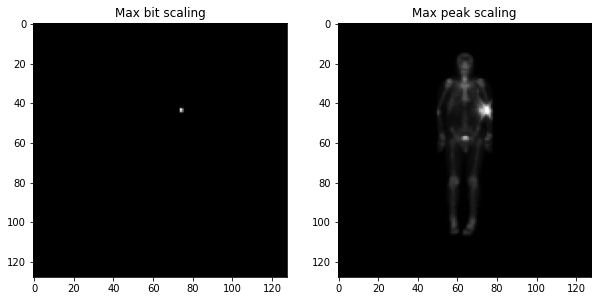

In [108]:
show_image(15048076)

In [110]:
predicted_metadata_df.sort_values("Difference center", axis=0, ascending=True)

,Index,Predicted window center (with metadata),Actual window center,Difference center,Predicted window width (with metadata),Actual window width,Difference width
798,20534882,49.979027,50.0,0.020973,731.844971,250.0,481.844971
1800,16708364,380.046967,380.0,0.046967,492.502899,438.0,54.502899
4214,30010241,2095.062012,2095.0,0.062012,2568.801514,2470.0,98.801514
39,13215664,39.877934,40.0,0.122066,917.978027,300.0,617.978027
2661,28693112,45.137314,45.0,0.137314,588.393982,360.0,228.393982
...,...,...,...,...,...,...,...
4600,11441474,6373.900391,13873.0,7499.099609,13139.395508,27746.0,14606.604492
1721,10859195,2600.987549,10196.0,7595.012451,5052.831055,20392.0,15339.168945
4338,16326553,1936.746704,9901.0,7964.253296,3879.633789,19802.0,15922.366211
4370,25902931,5177.696777,13568.0,8390.303223,10175.531250,27136.0,16960.468750


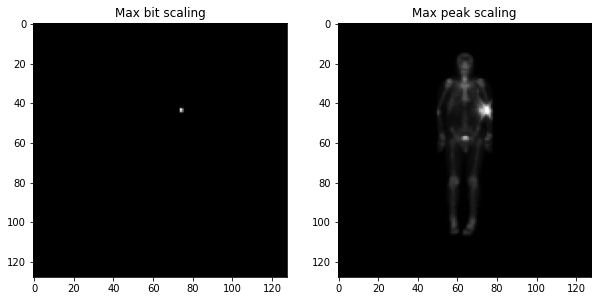

In [120]:
show_image(15048076)